In [32]:
import numpy as np
import scipy.integrate as integrate
import matplotlib as mpl
mpl.use('pgf')
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
from cycler import cycler
import scipy.interpolate
import matplotlib.ticker as mticker
import time
from scipy.optimize import curve_fit
import math
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [33]:
myColors = ["#009E73", "#0072B2", "#CC79A7", "#D55E00", "#56B4E9", "#F0E442", "#E69F00", "#000000"]
colors= ["white", myColors[4], myColors[1], myColors[0], myColors[5], myColors[6], myColors[3]]
myNodes = [0.0, 0.1, 0.2, 0.35, 0.5, 0.85, 1.0]
myCmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(myNodes, colors)))

colorsLog= ["white",  myColors[4], myColors[1], myColors[6], myColors[3], myColors[3]]
myNodesLog = [0.0, 0.1 , 0.2, 0.36, 0.6, 1]
myCmapLog = mpl.colors.LinearSegmentedColormap.from_list("mycmapLog", list(zip(myNodesLog, colorsLog)))

In [34]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams.update({
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 
plt.rcParams.update({'font.size': 15})

mpl.rcParams['axes.prop_cycle'] = cycler(color=myColors)

In [35]:
def RescalingCenters(DataSet, Nbins, Bins_limit=None):

    if Bins_limit==None:
        bins_max=DataSet[-1][0]
        bins_min=DataSet[0][0]
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]
        
    x_data=DataSet[:,0]
    bins_edges=np.logspace(np.log10(bins_min), np.log10(bins_max), Nbins+1)
    bins_centers = np.array([0.5 * (bins_edges[i] + bins_edges[i+1]) for i in range(Nbins)])
    y_data=DataSet[:,1]

    y_stackable = np.zeros(Nbins)

    for j in range(Nbins):
        for i in range(len(x_data)):
            if (x_data[i]<bins_edges[j+1])and(x_data[i]>bins_edges[j]):
                x_data[i]=bins_centers[j]
                y_stackable[j]=round(y_data[i])
            else:
                pass

        
    return bins_edges, bins_centers,  y_stackable

In [36]:
def DataStack(DataSets, Nbins, Bins_limit=None):

    if Bins_limit==None:
        a=np.empty(len(DataSets), dtype=object)
        for i in range(len(DataSets)):
            a[i] = DataSets[i][:,0]
        a=np.concatenate(a)
        
        bins_max=max(a)

        bins_min=min(a)

        bins_limit=(bins_min, bins_max)
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]


    y_stacked = np.zeros(Nbins)
    for i in range(len(DataSets)):

        bins_edges, bins_center, y_stackable = RescalingCenters(DataSets[i], Nbins, Bins_limit=(bins_min, bins_max))
        y_stacked += y_stackable
    

    return bins_edges, bins_center, y_stacked

In [37]:
def LogGaussian(x, s, mu):
    return (1 / (s*np.sqrt(2 * np.pi))) * np.exp(-(np.log10(x) - mu)**2 / (2 * s**2))
    

In [38]:
def LogGaussianfit(x, y, s_interval=None, mu_interval=None):
    x_fit = np.logspace(np.log10(min(x)), np.log10(max(x)), 100) 
    
    if s_interval==None:
        s_min=None
        s_max=None
    else: 
        s_min, s_max=s_interval
    if mu_interval==None:
        mu_min=None
        mu_max=None
    else: 
        mu_min, mu_max=mu_interval

    popt, pcov = curve_fit(LogGaussian, x, y,  bounds=([s_min, mu_min], [s_max, mu_max]))
    y_fit = LogGaussian(x_fit, *popt)
    return x_fit, y_fit, pcov

In [39]:
#Hirano 2014
pathfit_Hirano2014 = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Hirano2014/'
name_Hirano2014 = ['Total', 'Bins']
Hirano2014 = np.empty(len(name_Hirano2014), dtype=object)
Nbins_Hirano2014 = 26
for i in range(len(name_Hirano2014)):
    Hirano2014[i] = np.genfromtxt(pathfit_Hirano2014 + name_Hirano2014[i] +'.csv', delimiter=';')

Bins_Hirano2014_min = Hirano2014[-1][0][0]
Bins_Hirano2014_max = Hirano2014[-1][1][0]
Bins_limit_Hirano2014=(9.9, 1700)

Hirano2014_edges, Hirano2014_centers, Hirano2014_Y = DataStack(Hirano2014, Nbins_Hirano2014)

In [40]:
Hirano2014_centers_fitted, Hirano2014_Y_fitted, Err_H2014 = LogGaussianfit(Hirano2014_centers, Hirano2014_Y, (0.3,1), (1,3))

array([   7.45205192,    9.20939506,   11.38115493,   14.06505928,
         17.38188205,   21.48087808,   26.5464995 ,   32.80669594,
         40.54317212,   50.10406439,   61.91960661,   76.5214904 ,
         94.56679094,  116.86753488,  144.42724104,  178.48607807,
        220.57667124,  272.59306956,  336.87597676,  416.31808137,
        514.49422587,  635.82227219,  785.76190264,  971.06030198,
       1200.05577633, 1483.05297144])

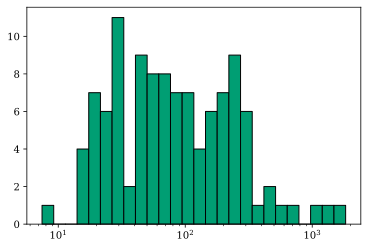

In [41]:
plt.bar(Hirano2014_edges[:-1], Hirano2014_Y, width=np.diff(Hirano2014_edges), ec="k", align="edge")
# plt.plot(Hirano2014_centers_fitted, Hirano2014_Y_fitted)

plt.xscale('log')
Hirano2014_edges[:-1]

In [42]:
#Susa2014

pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_susa = ['z<10', '10<z<14', '14<z']
Susa = np.empty(len(name_susa), dtype=object)
for i in range(len(name_susa)):
    Susa[i] = np.genfromtxt(pathfit_susa + name_susa[i] +'.csv', delimiter=';')

Bins_limit_Susa=[[0.47109741431987984, 297.00189937790844]]
Nbins_Susa = 20


In [43]:
Susa_Y = np.empty(len(Susa), dtype=object)
Susa_edges = np.empty(len(Susa), dtype=object)
Susa_centers = np.empty(len(Susa), dtype=object)
Susa_centers_fits = np.empty(len(Susa), dtype=object)
Susa_Y_fits = np.empty(len(Susa), dtype=object)
for i in range(len(Susa)):
    Susa_edges[i], Susa_centers[i], Susa_Y[i] =RescalingCenters(Susa[i], Nbins_Susa, Bins_limit=[0.47109741431987984, 297.00189937790844])
    Susa_centers_fits[i], Susa_Y_fits[i], Err_H2014 = LogGaussianfit(Susa_centers[i], Susa_Y[i], (0.7,1), (1,2.5))

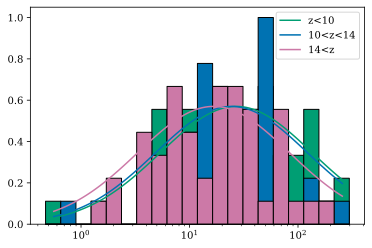

In [44]:
for i in range(3):
    plt.bar(Susa_edges[i][:-1], Susa_Y[i]/9, width=np.diff(Susa_edges[i]), ec="k", align="edge")    
    plt.plot(Susa_centers_fits[i], Susa_Y_fits[i], label=f'{name_susa[i]}')
plt.xscale('log')
plt.legend()

In [45]:
#Stacy 2013
def Stacy2013(M, M_min, M_max):
    IMF = M**(-0.17)
    N = integrate.quad(lambda M: IMF, M_min, M_max, epsrel=1e-2)[0]
    return IMF/N

In [46]:
#Hirano 2015
name_Hirano2015 = ['Total', '10<z<14', '14<z<18', '18<z<22', '22<z<26', '26<z<30', 'Bins']

pathfit_Hirano2015= '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Hirano2015/'
Hirano2015 = np.empty(len(name_Hirano2015), dtype=object)
for i in range(len(name_Hirano2015)):
    Hirano2015[i] = np.genfromtxt(pathfit_Hirano2015 + name_Hirano2015[i] +'.csv', delimiter=';')

Nbins_Hirano2015 = len(Hirano2015[0])
Bins_Hirano2015_min = min(Hirano2015[-1][:,0])
Bins_Hirano2015_max = max(Hirano2015[-1][:,0])
Bins_limit_Hirano2015=(Bins_Hirano2015_min, Bins_Hirano2015_max)


Hirano2015_Y=np.empty(len(Hirano2015), dtype=object)
Hirano2015_edges = np.empty(len(Hirano2015), dtype=object)
Hirano2015_centers = np.empty(len(Hirano2015), dtype=object)

for i in range(len(Hirano2015)):
    Hirano2015_edges[i], Hirano2015_centers[i], Hirano2015_Y[i] = RescalingCenters(Hirano2015[i], Nbins_Hirano2015, Bins_limit=Bins_limit_Hirano2015)


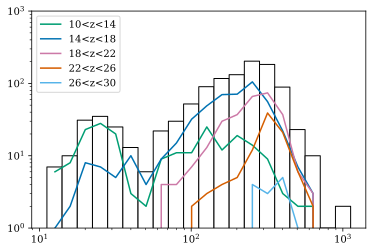

In [47]:
plt.bar(Hirano2015_edges[0][:-1], Hirano2015_Y[0], width=np.diff(Hirano2015_edges[i]), ec="k", align="edge", color='white')
for i in range(1, len(Hirano2015)-1):
    plt.plot(Hirano2015_centers[i], Hirano2015_Y[i], label=f'{name_Hirano2015[i]}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1, 1000)
plt.legend()

In [48]:
def Stacy2013(M, M_min, M_max):
    IMF = M**(-0.17)
    N = integrate.quad(lambda M: IMF, M_min, M_max, epsrel=1e-2)[0]
    return IMF/N


No handles with labels found to put in legend.


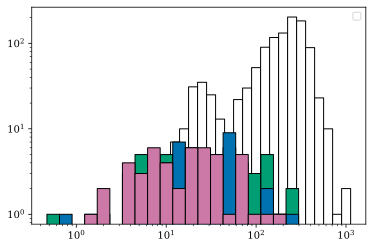

In [49]:
plt.bar(Hirano2015_edges[0][:-1], Hirano2015_Y[0], width=np.diff(Hirano2015_edges[i]), ec="k", align="edge", color='white')
for i in range(len(Susa_Y)):
    plt.bar(Susa_edges[i][:-1], Susa_Y[i], width=np.diff(Susa_edges[i]), ec="k", align="edge")   
plt.yscale('log')
plt.xscale('log')
plt.legend()

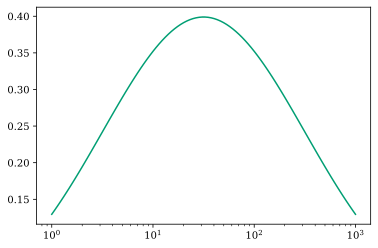

In [50]:
x=np.logspace(0,3, 100)
y=LogGaussian(x, 1, 1.5)
plt.plot(x, y)
plt.xscale('log')

In [51]:
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_N_per_halo = 'Stars_per_minihalo'
N_per_halos = np.rint(np.genfromtxt(pathfit_susa + 'N_per_halos' +'.csv'))
x_bins=np.arange(1,7,1)
print(x_bins, N_per_halos)


[1 2 3 4 5 6] [21. 11. 14.  8.  1.  4.]


In [52]:
def PowerLaw(x, A, a):
    return A*np.exp(-x*a)

In [53]:
x_fit_NH = np.arange(1, 7, 0.1)
sample=[]
popt, pcov = curve_fit(PowerLaw, x_bins, N_per_halos,  bounds=([18, 0], [30, 10]))
y_fit_NH = PowerLaw(x_fit_NH, *popt)
A, a = popt
A, a

(29.368751137366715, 0.36392374230481844)

Text(0, 0.5, 'Number of halo')

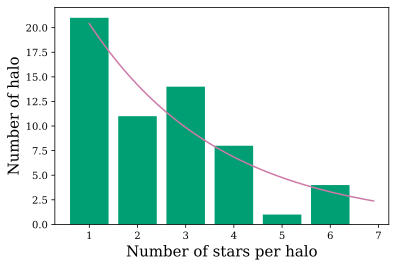

In [54]:
plt.bar(x_bins, N_per_halos)
plt.plot(x_fit_NH, y_fit_NH, color=myColors[2])
plt.xlabel('Number of stars per halo')
plt.ylabel('Number of halo')

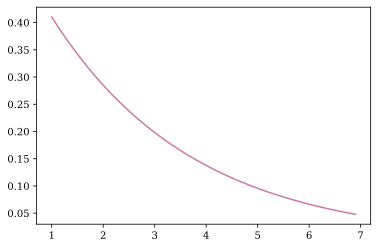

In [55]:
N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
y_fit_norm = y_fit_NH/N_NH
plt.plot(x_fit_NH, y_fit_norm, color=myColors[2])

We want to build a monte carlo that return the number of star par mass of halos with an associated mass. 
To do so we needed the IMF of the halos, the distribution of stars in the halos and their IMFwe have now everything we wanted to perform this.

In [56]:
#P.D.F. of the halo IMF 
from ipynb.fs.full.PressSchechter import HaloMassFunction 

HMF = HaloMassFunction(0, logmass_lim=(4, 20), Nbins=100)

H_IMF_inter = HMF.interpolates[1]


In [57]:
#Possible halo mass range 10^3-10^7

HM_interval=(10**3, 10**7)
H_IMF_Norm = integrate.quad(HMF.dndm_gen, 10**3, 10**7, args=(H_IMF_inter))[0]
def H_PDF(M):
    return HMF.dndm_gen(M, H_IMF_inter)/H_IMF_Norm

In [72]:
gen = np.random.default_rng()
n_halos=100000

def StarsGenerator(ninput):
    Minterval=(10**3, 10**7)

    fmax=H_PDF(10**3)+0.02*H_PDF(10**3)
    x_output=np.array([])
    
    ii=0
    t=[]
    while ii<ninput:
        t0      =time.time()
        t.append(time.time()-t0)
        x = gen.uniform(*Minterval, ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= H_PDF(x))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        ii+=len(x_accepted)

        if(ii==100):
            t_tot =np.mean(t)*ninput
            print(" Time for 1 loop is approx:", np.mean(t)
                , "\n Comp is finished in ", t_tot, "s"
                , " = " , t_tot/60 , "min" )
    return x_output



In [73]:
Halos = StarsGenerator(n_halos)

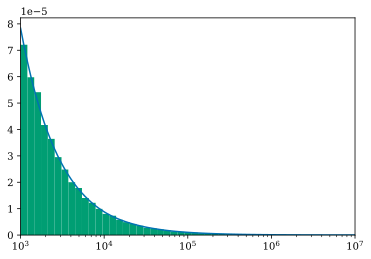

In [74]:
plt.hist(Halos, density=True, bins=10**np.linspace(3, 7, 50))
M=np.logspace(3, 7, 100)
plt.plot(M, H_PDF(M))
plt.xlim(10**3, 10**7)
plt.xscale('log')

We have generated a sample of halos between 10^5 to 10^7 Msun followinf the HIMF.
We will now consider different popIII IMF (starting with the Susa 2014)

In [61]:
def POPIII_PDF(M):
    L= LogGaussian(M, 0.70000001, 1.43117402)
    N=integrate.quad(LogGaussian, 0, 10**3, args=(0.70000001, 1.43117402))[0]
    return L/N
    

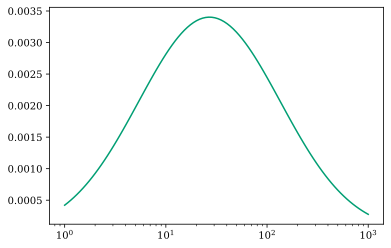

In [62]:
M=np.logspace(0, 3, 100)
plt.plot(M, POPIII_PDF(M))
plt.xscale('log')